# DeepLab Demo

This demo will demostrate the steps to run deeplab semantic segmentation model on sample input images.

In [40]:
#@title Imports

import cv2
import os
from io import BytesIO
import tarfile
import tempfile
from six.moves import urllib

from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
from datetime import datetime

import tensorflow as tf

In [41]:
#@title Helper methods


class DeepLabModel(object):
  """Class to load deeplab model and run inference."""

  INPUT_TENSOR_NAME = 'ImageTensor:0'
  OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
  INPUT_SIZE = 513
  FROZEN_GRAPH_NAME = 'frozen_inference_graph'

  def __init__(self, tarball_path):
    """Creates and loads pretrained deeplab model."""
    self.graph = tf.Graph()

    graph_def = None
    # Extract frozen graph from tar archive.
    tar_file = tarfile.open(tarball_path)
    for tar_info in tar_file.getmembers():
      if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
        file_handle = tar_file.extractfile(tar_info)
        graph_def = tf.GraphDef.FromString(file_handle.read())
        break

    tar_file.close()

    if graph_def is None:
      raise RuntimeError('Cannot find inference graph in tar archive.')

    with self.graph.as_default():
      tf.import_graph_def(graph_def, name='')

    self.sess = tf.Session(graph=self.graph)

  def run(self, image):
    """Runs inference on a single image.

    Args:
      image: A PIL.Image object, raw input image.

    Returns:
      resized_image: RGB image resized from original input image.
      seg_map: Segmentation map of `resized_image`.
    """
#     width, height = image.size
#     resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
#     target_size = (int(resize_ratio * width), int(resize_ratio * height))
#     resized_image = image.convert('RGB').resize(target_size, Image.ANTIALIAS)
#     print(type(resized_image), np.array(resized_image).shape)
    resized_image = image
    batch_seg_map = self.sess.run(
        self.OUTPUT_TENSOR_NAME,
        feed_dict={self.INPUT_TENSOR_NAME: [np.asarray(resized_image)]})
    seg_map = batch_seg_map[0]
    return resized_image, seg_map


def create_pascal_label_colormap():
  """Creates a label colormap used in PASCAL VOC segmentation benchmark.

  Returns:
    A Colormap for visualizing segmentation results.
  """
  colormap = np.zeros((256, 3), dtype=int)
  ind = np.arange(256, dtype=int)

  for shift in reversed(range(8)):
    for channel in range(3):
      colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

  return colormap


def label_to_color_image(label):
  """Adds color defined by the dataset colormap to the label.

  Args:
    label: A 2D array with integer type, storing the segmentation label.

  Returns:
    result: A 2D array with floating type. The element of the array
      is the color indexed by the corresponding element in the input label
      to the PASCAL color map.

  Raises:
    ValueError: If label is not of rank 2 or its value is larger than color
      map maximum entry.
  """
  if label.ndim != 2:
    raise ValueError('Expect 2-D input label')

  colormap = create_pascal_label_colormap()

  if np.max(label) >= len(colormap):
    raise ValueError('label value too large.')

  return colormap[label]


def vis_segmentation(image, seg_map):
  """Visualizes input image, segmentation map and overlay view."""
  plt.figure(figsize=(15, 5))
  grid_spec = gridspec.GridSpec(1, 4, width_ratios=[6, 6, 6, 1])

  plt.subplot(grid_spec[0])
  plt.imshow(image)
  plt.axis('off')
  plt.title('input image')

  plt.subplot(grid_spec[1])
  seg_image = label_to_color_image(seg_map).astype(np.uint8)
  plt.imshow(seg_image)
  plt.axis('off')
  plt.title('segmentation map')

  plt.subplot(grid_spec[2])
  plt.imshow(image)
  plt.imshow(seg_image, alpha=0.7)
  plt.axis('off')
  plt.title('segmentation overlay')

  unique_labels = np.unique(seg_map)
  ax = plt.subplot(grid_spec[3])
  plt.imshow(
      FULL_COLOR_MAP[unique_labels].astype(np.uint8), interpolation='nearest')
  ax.yaxis.tick_right()
  plt.yticks(range(len(unique_labels)), LABEL_NAMES[unique_labels])
  plt.xticks([], [])
  ax.tick_params(width=0.0)
  plt.grid('off')
  plt.show()

def read_labels(filename):
    names_ar = []
    f = open(filename, "r")
    i = 0
    for line in f:
        s = line.split("\t")
        names_ar.append(s[4][0:-1])
        i = i + 1
    return names_ar

labels = read_labels("objectInfo150.txt")
LABEL_NAMES = np.asarray(labels)
FULL_LABEL_MAP = np.arange(len(LABEL_NAMES)).reshape(len(LABEL_NAMES), 1)
FULL_COLOR_MAP = label_to_color_image(FULL_LABEL_MAP)

In [42]:
#@title Select and download models {display-mode: "form"}

MODEL_NAME = 'mobilenetv2_ade20k_train'  # @param ['mobilenetv2_coco_voctrainaug', 'mobilenetv2_coco_voctrainval', 'xception_coco_voctrainaug', 'xception_coco_voctrainval']

_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'
_MODEL_URLS = {
    'mobilenetv2_ade20k_train':
        'deeplabv3_mnv2_ade20k_train_2018_12_03.tar.gz',
}
_TARBALL_NAME = 'deeplab_model.tar.gz'

model_dir = tempfile.mkdtemp()
tf.gfile.MakeDirs(model_dir)

download_path = os.path.join(model_dir, _TARBALL_NAME)
print('downloading model, this might take a while...')
urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + _MODEL_URLS[MODEL_NAME],
                   download_path)
print('download completed! loading DeepLab model...')

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

downloading model, this might take a while...
download completed! loading DeepLab model...
model loaded successfully!


## Run on sample images

Select one of sample images (leave `IMAGE_URL` empty) or feed any internet image
url for inference.

Note that we are using single scale inference in the demo for fast computation,
so the results may slightly differ from the visualizations in
[README](https://github.com/tensorflow/models/blob/master/research/deeplab/README.md),
which uses multi-scale and left-right flipped inputs.

<class 'bytes'>
255
running deeplab on image https://pp.userapi.com/c846523/v846523878/1dc8da/ATPwYS-bFpc.jpg?raw=true...


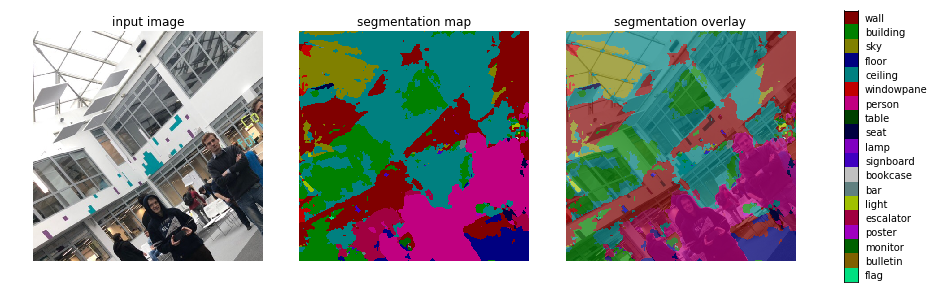

0:00:01.242401


In [49]:
#@title Run on sample images {display-mode: "form"}

SAMPLE_IMAGE = 'ATPwYS-bFpc'  # @param ['image1', 'image2', 'image3']
IMAGE_URL = ''  #@param {type:"string"}

#_SAMPLE_URL = ('https://github.com/tensorflow/models/blob/master/research/'
#               'deeplab/g3doc/img/%s.jpg?raw=true')
_SAMPLE_URL = ('https://pp.userapi.com/c846523/v846523878/1dc8da/%s.jpg?raw=true')


def run_visualization(url):
  """Inferences DeepLab model and visualizes result."""
  try:
    f = urllib.request.urlopen(url)
    jpeg_str = f.read()
    original_im = Image.open(BytesIO(jpeg_str))
    print(type(jpeg_str))
    print(np.array(original_im).max())
  except IOError:
    print('Cannot retrieve image. Please check url: ' + url)
    return

  print('running deeplab on image %s...' % url)
  original_im = original_im.crop((0, 0, 513, 513))
  resized_im, seg_map = MODEL.run(original_im)

  vis_segmentation(resized_im, seg_map)


image_url = IMAGE_URL or _SAMPLE_URL % SAMPLE_IMAGE
start_time = datetime.now()
run_visualization(image_url)
end_time = datetime.now()
print (end_time - start_time)

Procesed 10
Procesed 20
Procesed 30
Procesed 40
Procesed 50
Procesed 60
Procesed 70
Procesed 80
Procesed 90
Procesed 100
Procesed 110
Procesed 120
Procesed 130
Procesed 140
Procesed 150
Procesed 160
Procesed 170
Procesed 180
Procesed 190
Procesed 200
Procesed 210
Procesed 220
Procesed 230
Procesed 240
Procesed 250
Procesed 260
Procesed 270
Procesed 280
Procesed 290
0:00:04.403214


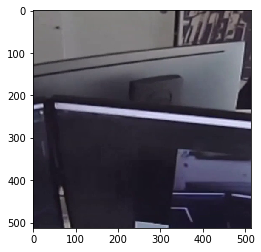

In [52]:
cap = cv2.VideoCapture('/Users/gleonett/Desktop/CV_lab/test_ARnavigation.mp4')
img_l = []
i = 0
start_time = datetime.now()
while(cap.isOpened()):
    ret, frame = cap.read()
    img = Image.fromarray(frame[...,::-1])
    img = img.crop((226, 104, 739, 617))
    img_l.append(img)
    if not ret:
        break
    i+=1
    if i%10 == 0:
        print("Procesed {}".format(i))
    if i == 299:
        break

cap.release()

end_time = datetime.now()
print (end_time - start_time)
# img = img.crop((0, 0, 513, 513))
# p = img.crop((226, 104, 739, 617))
plt.imshow(img_l[10])
# plt.imshow(p)

In [45]:
# cap = cv2.VideoCapture('/Users/gleonett/Desktop/CV_lab/lol.mp4')
sigm_l = []
im_l = []
i = 0
start_time = datetime.now()
while(i < 290):
#     ret, frame = cap.read()
#     img = Image.fromarray(frame[...,::-1])
    resized_im, seg_map = MODEL.run(img_l[i])
    sigm_l.append(seg_map)
    im_l.append(resized_im)
    if i%10 == 0:
        print("Procesed {}".format(i))
    i+=1
end_time = datetime.now()
print(end_time - start_time)
# cap.release()

Procesed 0
Procesed 10
Procesed 20
Procesed 30
Procesed 40
Procesed 50
Procesed 60
Procesed 70
Procesed 80
Procesed 90
Procesed 100
Procesed 110
Procesed 120
Procesed 130
Procesed 140
Procesed 150
Procesed 160
Procesed 170
Procesed 180
Procesed 190
Procesed 200
Procesed 210
Procesed 220
Procesed 230
Procesed 240
Procesed 250
Procesed 260
Procesed 270
Procesed 280
0:02:59.186058


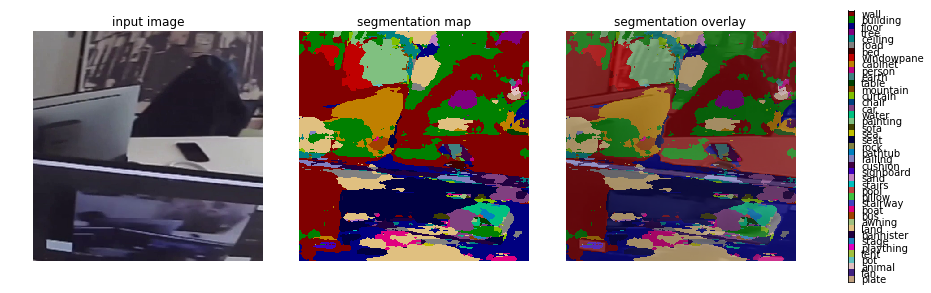

kek <class 'numpy.ndarray'> shape (720, 2160, 3)
<class 'PIL.Image.Image'>
(720, 2160, 3)


True

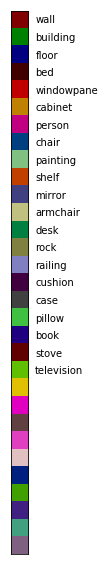

In [14]:

vis_segmentation(im_l[50], sigm_l[50])
plt.figure(figsize=(30, 10))
grid_spec = gridspec.GridSpec(1, 2)
unique_labels = np.unique(seg_map) 
ax = plt.subplot(grid_spec[0])
plt.imshow(FULL_COLOR_MAP[unique_labels].astype(np.uint8), interpolation='nearest')
ax.yaxis.tick_right()
plt.yticks(range(len(unique_labels) - 10), LABEL_NAMES[unique_labels])
plt.xticks([], [])
ax.tick_params(width=0.0)
plt.grid('off')
plt.savefig('plot.jpg')
img_plot = cv2.imread('plot.jpg')
print("kek", type(img_plot),"shape", img_plot.shape)
img = label_to_color_image(sigm_l[50]).astype(np.uint8)
dst = cv2.addWeighted(np.array(im_l[50]), 0.6, img, 0.4, 0)
b_im = np.zeros((408,1200,3), np.uint8)
b_im[::] = (255,255,255)
b_im = Image.fromarray(b_im, 'RGB')
dst = Image.fromarray(dst, 'RGB')
img3 = Image.fromarray(img_plot, 'RGB')
print(type(b_im))
print(np.array(img3).shape)
b_im.paste(img3, (-80,-80))
b_im.paste(dst, (0,0))
cv2.imwrite('./himg.jpg', np.array(b_im))


In [50]:
out = cv2.VideoWriter('./new_t.avi', cv2.VideoWriter_fourcc(*'PIM1'), 25, (513, 513))
i = 0
while (i < 290):
    img = label_to_color_image(sigm_l[i]).astype(np.uint8)
    res = cv2.addWeighted(np.array(im_l[i]), 0.6, img, 0.4, 0)
    #res2 = Image.fromarray(res, 'RGB')
    #b_im2.paste(res2, (0,0))
    #print(np.tile(segm_image[:,:,np.newaxis], 3).shape)
    out.write(np.array(res).astype('uint8'))
    if i%20 == 0:
        print("Procesed {}".format(i))
    i += 1
out.release()

Procesed 0
Procesed 20
Procesed 40
Procesed 60
Procesed 80
Procesed 100
Procesed 120
Procesed 140
Procesed 160
Procesed 180
Procesed 200
Procesed 220
Procesed 240
Procesed 260
Procesed 280
